# Analisis del modelo entrenado

He entrenado el modelo en el HPMOON con los datos de PSM, de la misma forma que indicaba el paper, practicamente calcado el entrenamiento, ahora me falta hacer la inferencia e investigar como funciona el modelo. 

No creo que pueda hacer inferencia en local, pero lo intentaré.



In [1]:
#tenemos que agregar al sys path el directorio
import sys
import os 
AssDis_path=f"{os.path.abspath('../..')}/Anomaly-Transformer"
sys.path.append(AssDis_path)

In [2]:

import numpy as np 
import torch
import matplotlib.pyplot as plt 
import time
from torch import nn

import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import collections
import numbers
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

from model.AnomalyTransformer import AnomalyTransformer


In [3]:
BASE_dir=f"{os.path.abspath('../..')}/TFM/1-AnomalyTranformer_MIO/ejecucion_remota"
dataset_name="PSM"

datapath=f"{BASE_dir}/data/{dataset_name}"
model_save_path=f"{BASE_dir}/results_y_models/1-PSM_models"

if (not os.path.exists(model_save_path)):
    print(f"creado {model_save_path}")
    os.mkdir(model_save_path)



In [4]:

#funcion para ocntar los parametros del modelo 
def count_parameters(model):
    total=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total}")
    return total


In [5]:

class PSMSegLoader(object): ##y esto no deberia heredar de dataset?
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()
        data = pd.read_csv(data_path + '/train.csv')
        data = data.values[:, 1:]

        data = np.nan_to_num(data)

        self.scaler.fit(data)
        data = self.scaler.transform(data)
        test_data = pd.read_csv(data_path + '/test.csv')

        test_data = test_data.values[:, 1:]
        test_data = np.nan_to_num(test_data)

        self.test = self.scaler.transform(test_data)

        self.train = data
        self.val = self.test

        self.test_labels = pd.read_csv(data_path + '/test_label.csv').values[:, 1:] ## y los labels de train ?

        print("test:", self.test.shape)
        print("train:", self.train.shape)

    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'val'):
            return (self.val.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'test'):
            return (self.test.shape[0] - self.win_size) // self.step + 1
        else:
            return (self.test.shape[0] - self.win_size) // self.win_size + 1
            #por eso su longitud es entre el winsize

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'val'):
            return np.float32(self.val[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'test'):
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])
        else:
            return np.float32(self.test[
                              index // self.step * self.win_size : index // self.step * self.win_size + self.win_size]), np.float32(
                self.test_labels[index // self.step * self.win_size:index // self.step * self.win_size + self.win_size])
        #esto lo que hace es devolver TEST SIN SOLAPAMIENTO!



def get_loader_segment(data_path, batch_size, win_size=100, step=100, mode='train', dataset='KDD'):
    # if (dataset == 'SMD'):
    #     dataset = SMDSegLoader(data_path, win_size, step, mode)
    # elif (dataset == 'MSL'):
    #     dataset = MSLSegLoader(data_path, win_size, 1, mode)
    # elif (dataset == 'SMAP'):
    #     dataset = SMAPSegLoader(data_path, win_size, 1, mode)
    # elif (dataset == 'PSM'):

    dataset = PSMSegLoader(data_path, win_size, 1, mode)

    shuffle = False
    if mode == 'train':
        shuffle = True

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=0)
    return data_loader



class EarlyStopping:
    def __init__(self, patience=7, verbose=False, dataset_name='', delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_score2 = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_loss2_min = np.Inf
        self.delta = delta
        self.dataset = dataset_name

    def __call__(self, val_loss, val_loss2, model, path):
        score = -val_loss
        score2 = -val_loss2
        if self.best_score is None:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
        elif score < self.best_score + self.delta or score2 < self.best_score2 + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, val_loss2, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), os.path.join(path, str(self.dataset) + '_checkpoint.pth'))
        self.val_loss_min = val_loss
        self.val_loss2_min = val_loss2



#para el modelo en sí

def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)


def adjust_learning_rate(optimizer, epoch, lr_):
    lr_adjust = {epoch: lr_ * (0.5 ** ((epoch - 1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))
        


In [11]:
test_loader = get_loader_segment(datapath, batch_size=16, win_size=100,mode='test',dataset=dataset_name)
train_loader = get_loader_segment(datapath, batch_size=16, win_size=100,mode='train',dataset=dataset_name)
thre_loader = get_loader_segment(datapath, batch_size=16, win_size=100,mode='thre',dataset=dataset_name)


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
len(thre_loader)

55

In [ ]:
iter_aux=iter(test_loader)
for i in range(100//16): 
    _=next(iter_aux)
a=next(iter_aux)
a[0], a[1] = a[0].to("cuda:0") , a[1].to("cuda:0")
b=next(iter(thre_loader))
b[0], b[1] = b[0].to("cuda:0") , b[1].to("cuda:0")

In [ ]:
print(a[0].shape,a[1].shape)

torch.Size([16, 100, 25]) torch.Size([16, 100, 1])


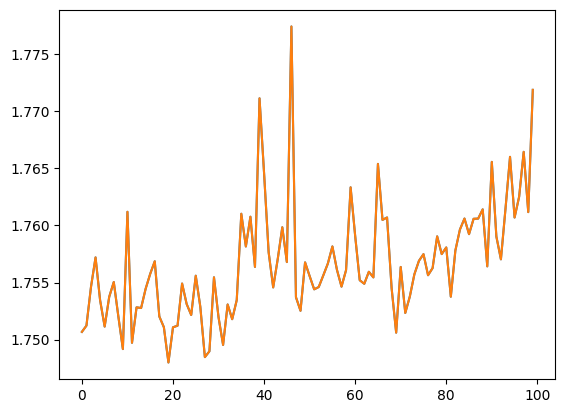

In [ ]:
plt.plot(a[0].cpu()[100%16,:,1])
plt.plot(b[0].cpu()[1,:,1])

In [ ]:
torch.cuda.device_count()


1

In [ ]:
win_size=100

model=AnomalyTransformer(win_size=win_size, enc_in=25, c_out=25, e_layers=3, d_model=512, n_heads=8)
model.load_state_dict(torch.load("./ejecucion_remota/results_y_models/1-PSM_models/PSM_checkpoint.pth"))#,map_location=torch.device('cpu')))
model=model.to("cuda:0")
model.eval()

AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(25, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (sigma_projection): Linear(in_features=512, out_features=8, bias=True)
          (out_projection): Linear(in_features=512, out_feat

In [ ]:
a[0].shape

torch.Size([16, 100, 25])

In [ ]:
output, series, prior, sigmas =model(a[0])

torch.Size([16, 100, 25])


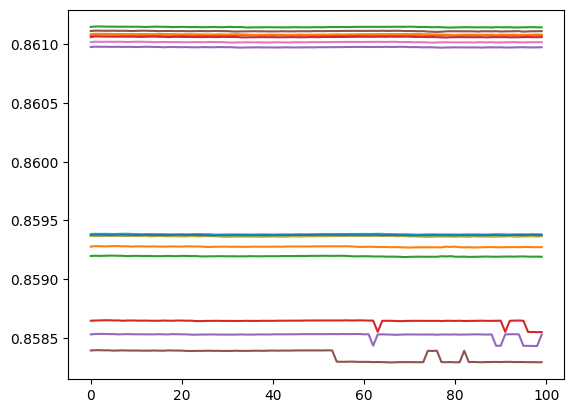

In [ ]:
print(output.shape)
for i in range(16):
    plt.plot(output.cpu().detach().numpy()[i,:,0])

Una cosa a tener en cuenta, es si lo datos estaban ordenados a la entrada. En teoria si. Vale esque los datos son con 1 step de diferencia. 

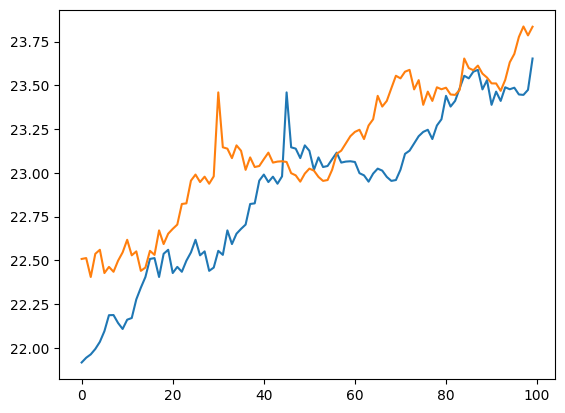

In [ ]:
plt.plot(a[0][0,:,0].cpu().detach().numpy())
plt.plot(a[0][15,:,0].cpu().detach().numpy())

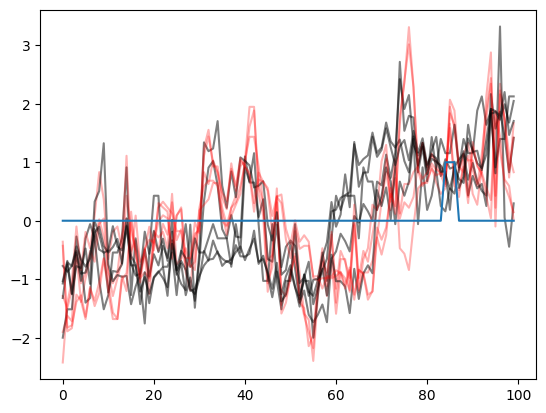

In [ ]:
i=5
for j in range(5,10):
    scaler=StandardScaler()
    plt.plot(scaler.fit_transform(output.cpu().detach().numpy()[i,:,j][...,np.newaxis]).squeeze(),color="red",alpha=0.3)
    scaler=StandardScaler()
    plt.plot(scaler.fit_transform(a[0].cpu().detach().numpy()[i,:,j][...,np.newaxis]).squeeze(),color="black",alpha=0.5)
plt.plot(a[1].cpu().detach().numpy()[i,:])

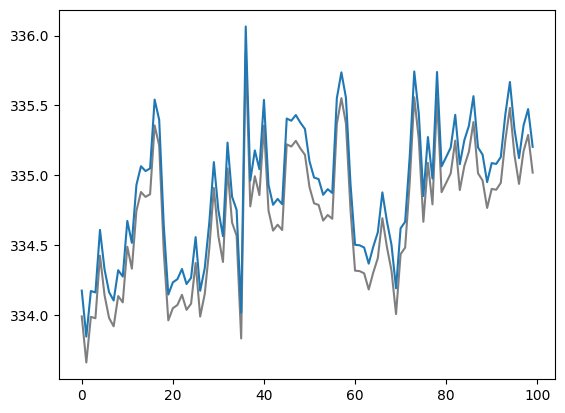

In [ ]:
i=9
j=1
plt.plot(a[0].cpu().detach().numpy()[i,:,j]-output.cpu().detach().numpy()[i,:,j],color="black",alpha=0.5)
plt.plot(a[0].cpu().detach().numpy()[i,:,j])

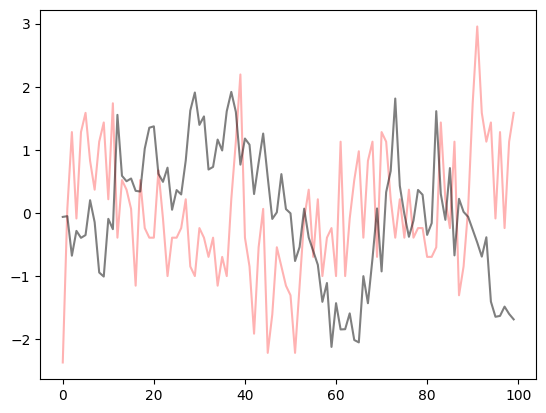

In [ ]:
i=8
j=14
scaler=StandardScaler()
plt.plot(scaler.fit_transform(output.cpu().detach().numpy()[i,:,j][...,np.newaxis]).squeeze(),color="red",alpha=0.3)
scaler=StandardScaler()
plt.plot(scaler.fit_transform(a[0].cpu().detach().numpy()[i,:,j][...,np.newaxis]).squeeze(),color="black",alpha=0.5)

En teoria esto anterior debería ser la reconstrucción la una de la otra, curioso. Pero bueno, comprobemos si las anomalias estan siendo detectadas. 

Antes de comprobar si se detectan las anomalías, investiguemos el restos de salidas del modelo.

In [ ]:
series_mean=torch.mean(torch.stack(series),0)


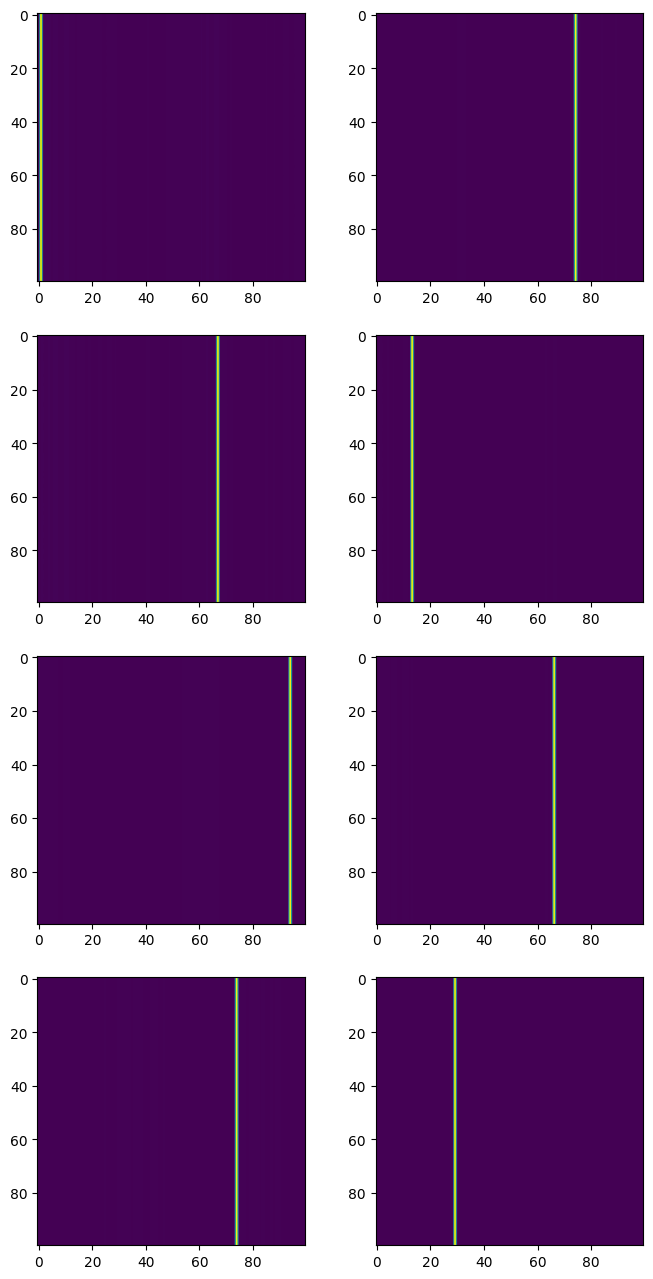

In [ ]:
plt.figure(figsize=(8,16))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.imshow(series_mean[6,i].cpu().detach().numpy())

In [ ]:
prior_mean=torch.mean(torch.stack(prior),0)


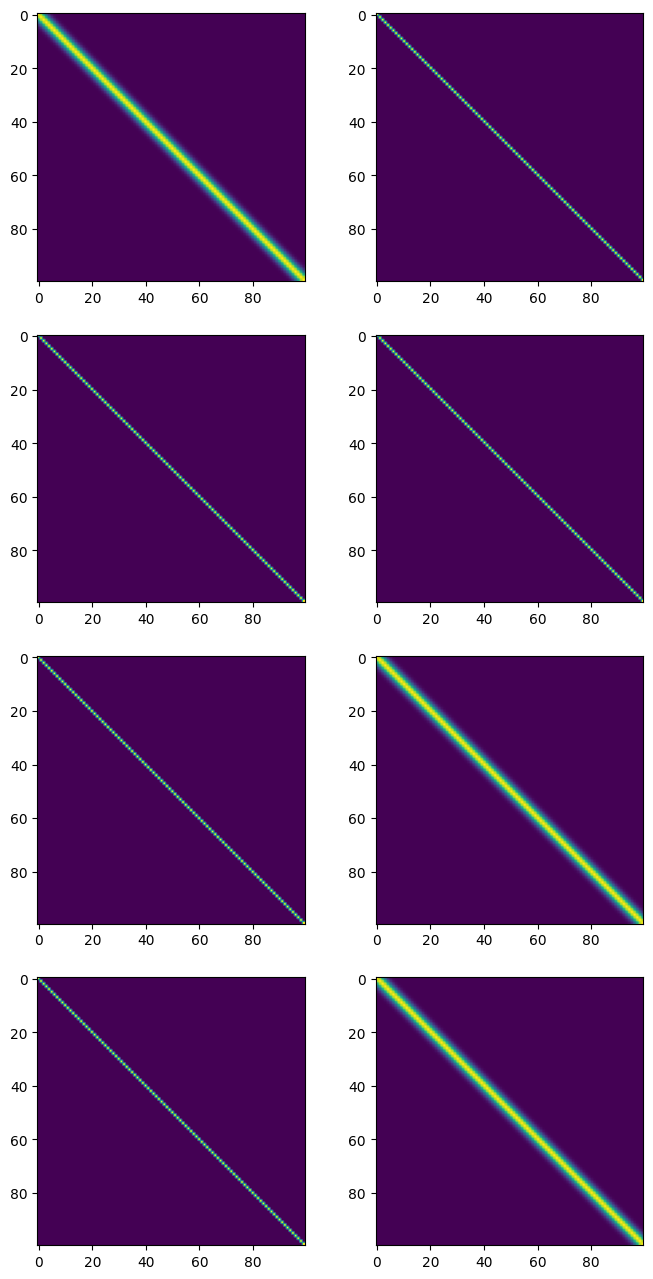

In [ ]:
plt.figure(figsize=(8,16))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.imshow(prior_mean[6,i].cpu().detach().numpy())

Las reconstrucciones son una mierda, algo tiene que estar pasando. 

In [ ]:
def test(self):
    self.model.load_state_dict(
        torch.load(
            os.path.join(str(self.model_save_path), str(self.dataset) + '_checkpoint.pth')))
    self.model.eval()
    temperature = 50

    print("======================TEST MODE======================")

    criterion = nn.MSELoss(reduce=False)

    # (1) stastic on the train set
    attens_energy = []
    for i, (input_data, labels) in enumerate(self.train_loader):
        input = input_data.float().to(self.device)
        output, series, prior, _ = self.model(input)
        loss = torch.mean(criterion(input, output), dim=-1)
        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            if u == 0:
                series_loss = my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                self.win_size)).detach()) * temperature
                prior_loss = my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            self.win_size)),
                    series[u].detach()) * temperature
            else:
                series_loss += my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                self.win_size)).detach()) * temperature
                prior_loss += my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            self.win_size)),
                    series[u].detach()) * temperature

        metric = torch.softmax((-series_loss - prior_loss), dim=-1)
        cri = metric * loss
        cri = cri.detach().cpu().numpy()
        attens_energy.append(cri)

    attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
    train_energy = np.array(attens_energy)

    # (2) find the threshold
    attens_energy = []
    for i, (input_data, labels) in enumerate(self.thre_loader):
        input = input_data.float().to(self.device)
        output, series, prior, _ = self.model(input)

        loss = torch.mean(criterion(input, output), dim=-1)

        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            if u == 0:
                series_loss = my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                self.win_size)).detach()) * temperature
                prior_loss = my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            self.win_size)),
                    series[u].detach()) * temperature
            else:
                series_loss += my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                self.win_size)).detach()) * temperature
                prior_loss += my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            self.win_size)),
                    series[u].detach()) * temperature
        # Metric
        metric = torch.softmax((-series_loss - prior_loss), dim=-1)
        cri = metric * loss
        cri = cri.detach().cpu().numpy()
        attens_energy.append(cri)

    attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
    test_energy = np.array(attens_energy)
    combined_energy = np.concatenate([train_energy, test_energy], axis=0)
    thresh = np.percentile(combined_energy, 100 - self.anormly_ratio)
    print("Threshold :", thresh)

    # (3) evaluation on the test set
    test_labels = []
    attens_energy = []
    for i, (input_data, labels) in enumerate(self.thre_loader):
        input = input_data.float().to(self.device)
        output, series, prior, _ = self.model(input)

        loss = torch.mean(criterion(input, output), dim=-1)

        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            if u == 0:
                series_loss = my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                self.win_size)).detach()) * temperature
                prior_loss = my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            self.win_size)),
                    series[u].detach()) * temperature
            else:
                series_loss += my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                self.win_size)).detach()) * temperature
                prior_loss += my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            self.win_size)),
                    series[u].detach()) * temperature
        metric = torch.softmax((-series_loss - prior_loss), dim=-1)

        cri = metric * loss
        cri = cri.detach().cpu().numpy()
        attens_energy.append(cri)
        test_labels.append(labels)

    attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
    test_labels = np.concatenate(test_labels, axis=0).reshape(-1)
    test_energy = np.array(attens_energy)
    test_labels = np.array(test_labels)

    pred = (test_energy > thresh).astype(int)

    gt = test_labels.astype(int)

    print("pred:   ", pred.shape)
    print("gt:     ", gt.shape)

    # detection adjustment
    anomaly_state = False
    for i in range(len(gt)):
        if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
            anomaly_state = True
            for j in range(i, 0, -1):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
            for j in range(i, len(gt)):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
        elif gt[i] == 0:
            anomaly_state = False
        if anomaly_state:
            pred[i] = 1

    pred = np.array(pred)
    gt = np.array(gt)
    print("pred: ", pred.shape)
    print("gt:   ", gt.shape)

    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(gt, pred)
    precision, recall, f_score, support = precision_recall_fscore_support(gt, pred,
                                                                            average='binary')
    print(
        "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
            accuracy, precision,
            recall, f_score))

    return accuracy, precision, recall, f_score


In [11]:
import torch
import os
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def test_model(model, train_loader, thre_loader , win_size, anormly_ratio, temperature=50,device="cuda:0"):
    
    model.eval()

    print("======================TEST MODE======================")

    criterion = nn.MSELoss(reduce=False)

    # (1) stastic on the train set
    attens_energy = []
    for i, (input_data, labels) in enumerate(train_loader):
        input = input_data.float().to(device)
        output, series, prior, _ = model(input)
        loss = torch.mean(criterion(input, output), dim=-1)
        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            if u == 0:
                series_loss = my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                               win_size)).detach()) * temperature
                prior_loss = my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)),
                    series[u].detach()) * temperature
            else:
                series_loss += my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                               win_size)).detach()) * temperature
                prior_loss += my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)),
                    series[u].detach()) * temperature

        metric = torch.softmax((-series_loss - prior_loss), dim=-1)
        cri = metric * loss
        cri = cri.detach().cpu().numpy()
        attens_energy.append(cri)

    attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
    train_energy = np.array(attens_energy)

    # (2) find the threshold
    attens_energy = []
    for i, (input_data, labels) in enumerate(thre_loader):
        input = input_data.float().to(device)
        output, series, prior, _ = model(input)

        loss = torch.mean(criterion(input, output), dim=-1)

        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            if u == 0:
                series_loss = my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                               win_size)).detach()) * temperature
                prior_loss = my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)),
                    series[u].detach()) * temperature
            else:
                series_loss += my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1
            , 1, win_size)).detach()) * temperature
            prior_loss += my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach()) * temperature
    # Metric
    metric = torch.softmax((-series_loss - prior_loss), dim=-1)
    cri = metric * loss
    cri = cri.detach().cpu().numpy()
    attens_energy.append(cri)

    attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
    test_energy = np.array(attens_energy)
    combined_energy = np.concatenate([train_energy, test_energy], axis=0)
    thresh = np.percentile(combined_energy, 100 - anormly_ratio)
    print("Threshold :", thresh)

    # (3) evaluation on the test set
    test_labels = []
    attens_energy = []
    for i, (input_data, labels) in enumerate(thre_loader):
        input = input_data.float().to(device)
        output, series, prior, _ = model(input)

        loss = torch.mean(criterion(input, output), dim=-1)

        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            if u == 0:
                series_loss = my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
                prior_loss = my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)),
                    series[u].detach()) * temperature
            else:
                series_loss += my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
                prior_loss += my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)),
                    series[u].detach()) * temperature
        metric = torch.softmax((-series_loss - prior_loss), dim=-1)

        cri = metric * loss
        cri = cri.detach().cpu().numpy()
        attens_energy.append(cri)
        test_labels.append(labels)

    attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
    test_labels = np.concatenate(test_labels, axis=0).reshape(-1)
    test_energy = np.array(attens_energy)
    test_labels = np.array(test_labels)

    pred = (test_energy > thresh).astype(int)

    gt = test_labels.astype(int)

    print("pred:   ", pred.shape)
    print("gt:     ", gt.shape)
    return pred, gt
    # # detection adjustment
    # anomaly_state = False
    # for i in range(len(gt)):
    #     if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
    #         anomaly_state = True
    #         for j in range(i, 0, -1):
    #             if gt[j] == 0:
    #                 break
    #             else:
    #                 if pred[j] == 0:
    #                     pred[j] = 1
    #         for j in range(i, len(gt)):
    #             if gt[j] == 0:
    #                 break
    #             else:
    #                 if pred[j] == 0:
    #                     pred[j] = 1
    #     elif gt[i] == 0:
    #         anomaly_state = False
    #     if anomaly_state:
    #         pred[i] = 1

    # pred = np.array(pred)
    # gt = np.array(gt)
    # print("pred: ", pred.shape)
    # print("gt:   ", gt.shape)

    # from sklearn.metrics import precision_recall_fscore_support
    # from sklearn.metrics import accuracy_score
    # accuracy = accuracy_score(gt, pred)
    # precision, recall, f_score, support = precision_recall_fscore_support(gt, pred,
    #                                                                     average='binary')
    # print(
    #     "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
    #         accuracy, precision,
    #         recall, f_score))

    # return accuracy, precision, recall, f_score


In [8]:
test_loader = get_loader_segment(datapath, batch_size=64, win_size=100,mode='test',dataset=dataset_name)
train_loader = get_loader_segment(datapath, batch_size=64, win_size=100,mode='train',dataset=dataset_name)
thre_loader = get_loader_segment(datapath, batch_size=64, win_size=100,mode='thre',dataset=dataset_name)


test: (87841, 25)
train: (132481, 25)
test: (87841, 25)
train: (132481, 25)
test: (87841, 25)
train: (132481, 25)


In [22]:
win_size=100

model=AnomalyTransformer(win_size=win_size, enc_in=25, c_out=25, e_layers=3, d_model=512, n_heads=8)
model.load_state_dict(torch.load("./ejecucion_remota/results_y_models/2-PSM_models/PSM_checkpoint.pth"))#,map_location=torch.device('cpu')))
model=model.to("cuda:0")
model.eval()

AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(25, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (sigma_projection): Linear(in_features=512, out_features=8, bias=True)
          (out_projection): Linear(in_features=512, out_feat

In [28]:
pred,gt=test_model(model, train_loader, thre_loader , 100, 0.1)

======================TEST MODE======================


/home/arturoSF/.conda/envs/pytorch/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Threshold : 0.018106941606850516
pred:    (87800,)
gt:      (87800,)


(52000.0, 84000.0)

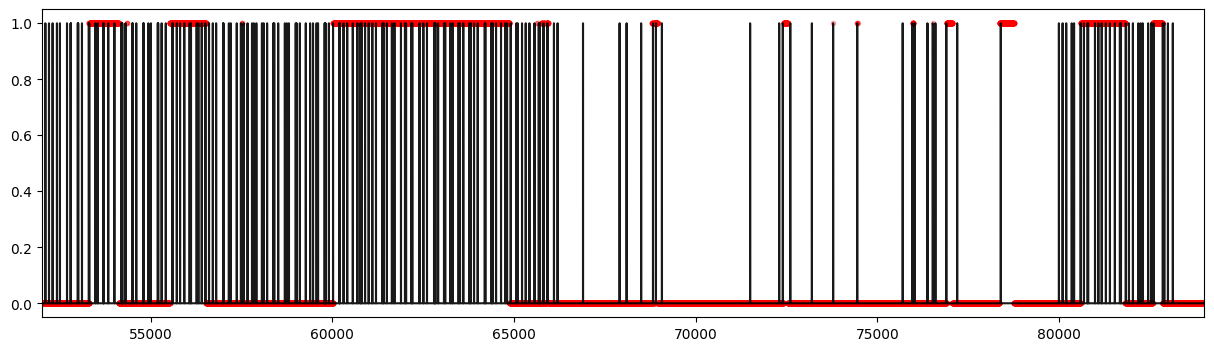

In [37]:
plt.figure(figsize=(15,4))
plt.plot(gt,".r",alpha=0.3)
plt.plot(pred,"k",alpha=0.9)

plt.xlim(52000,84000)